In [20]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, FunctionTransformer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

x = train.drop(columns=["Survived", "Cabin", "Ticket", "PassengerId"])
y = train["Survived"]

train["Title"] = train["Name"].str.extract(r" ([A-Za-z]+)\.", expand=False)
titles = train["Title"].value_counts()

def new_features(x):
    x_copy = x.copy()
    x_copy["Title"] = x_copy["Name"].str.extract(r" ([A-Za-z]+)\.", expand=False)
    x_copy["Title"] = x_copy["Title"].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    x_copy['Title'] =x_copy['Title'].replace('Mlle', 'Miss')
    x_copy['Title'] = x_copy['Title'].replace('Ms', 'Miss')
    x_copy['Title'] = x_copy['Title'].replace('Mme', 'Mrs')
    x_copy["FamilySize"] = x_copy["Parch"]+ x_copy["SibSp"] + 1
    x_copy["IsAlone"] = (x_copy["FamilySize"] == 1).astype(int)
    x_copy["FarePerPerson"] = x_copy["Fare"]/x_copy["FamilySize"]
    return x_copy.drop(columns=["Name"])

Feature_Eng = FunctionTransformer(new_features)

num_col = ["Age", "FamilySize", "IsAlone", "FarePerPerson","Fare"]
cat_col = ["Title", "Embarked"]

num_feature = Pipeline(steps=[
    ("Imputer", SimpleImputer(strategy="median")),
    ("Scaler", StandardScaler())
])
cat_feature = Pipeline(steps=[
    ("Imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessing = ColumnTransformer([
    ("num", num_feature, num_col),
    ("cat", cat_feature, cat_col)
])

Pipe = Pipeline(steps=[
    ("new_feature", Feature_Eng),
    ("preprocess", preprocessing),
    ("model", XGBClassifier(random_state=42,
                            eval_metric ="logloss",
                            ))
])


param_grid = {
    'model__n_estimators':[100, 400],
    'model__max_depth': [3, 4, 5],
    'model__learning_rate':[0.01, 0.05, 0.1],
    'model__subsample': [0.8, .9],
    "model__colsample_bytree": [0.8, .9, 1.0],
}

grid = GridSearchCV(
    estimator= Pipe,
    param_grid= param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs= -1,
    verbose= 2
)

grid.fit(x, y)

print("Best Parameters:")
print(grid.best_params_)

print("\nBest CV Accuracy:")
print(grid.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters:
{'model__colsample_bytree': 0.8, 'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 400, 'model__subsample': 0.8}

Best CV Accuracy:
0.8751734608337298


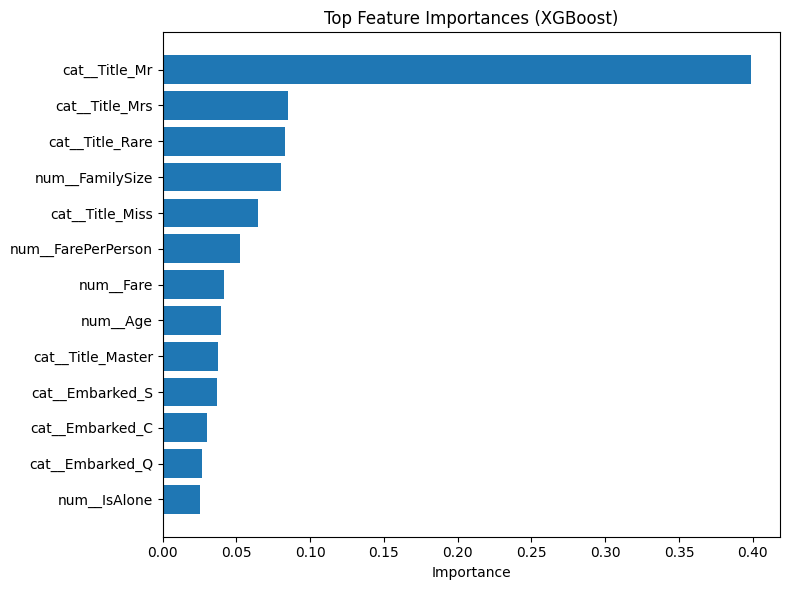

In [21]:
import matplotlib.pyplot as plt
best_model = grid.best_estimator_
xgb_model = best_model.named_steps["model"]
importances = xgb_model.feature_importances_
preprocessor = best_model.named_steps["preprocess"]

feature_names = preprocessor.get_feature_names_out()
importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)
top_n = 20
plot_df = importance_df.head(top_n)[::-1]

plt.figure(figsize=(8, 6))
plt.barh(plot_df["feature"], plot_df["importance"])
plt.title("Top Feature Importances (XGBoost)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()
